# Future frequency of threshold exceedance under different climate change scenarios

In this chapter the future frequency of threshold exceendance is determined. This is done using different climate change scenarios, which are implemented in the HBV model. To be able to project the future discharge scenarios, the HBV model needs to be calibrated using observation data. The HBV model requires forcings, rainfall and potential evaporation, as inputs. With a set of parameters, which have to be calibrated, it can calculate the modelled discharge at the outlet of the catchment. 

## General

First of all, some general python and eWaterCycle libraries need to be imported:

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print

#needed
from ipywidgets import IntProgress
from IPython.display import display

# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

As stated in chapter 3, eWaterCycle provides access to the Caravan dataset, from which a Camel dataset of the catchment of the Wien River is loaded:

In [2]:
camelsgb_id = "lamah_208082"

  The start and end date of the experiment have to be specified. The start and end date of the calibration have to be specified as well. The period of calibration is chosen to be around 75% of the experiment period. This means that the model is trained on 75% of the observation data, and can be tested on 25% of the observation data, to make sure the model is not only working for the data it was trained on, but on other periods of data as well. 

In [3]:
# calibration dates op 75% van de experiment dates zetten!!!

experiment_start_date = "1981-08-01T00:00:00Z"
experiment_end_date = "2023-08-31T00:00:00Z"

calibration_start_time = experiment_start_date
calibration_end_time = "2010-08-31T00:00:00Z"

The forcing data can be generated or previously generated data can be loaded:

In [4]:
# Even though we don't use caravan data as forcing, we still call it forcing
# because it is generated using the forcing module of eWaterCycle
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
prepared_forcing_path_caravan_central = Path("location/of/forcing/data")

In [5]:
# option one: generate forcing data
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
    start_time=experiment_start_date,
    end_time=experiment_end_date,
    directory=forcing_path_caravan,
    basin_id=camelsgb_id,
)


# # option two or three: load data that you or someone else generated previously
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))

print(camelsgb_forcing)

CaravanForcing(
    start_time='1981-08-01T00:00:00Z',
    end_time='2023-08-31T00:00:00Z',
    directory=PosixPath('/home/thirza/forcing/lamah_208082/caravan'),
    shape=PosixPath('/home/thirza/forcing/lamah_208082/caravan/lamah_208082.shp'),
    filenames={
        'tasmax': 'lamah_208082_1981-08-01_2023-08-31_tasmax.nc',
        'Q': 'lamah_208082_1981-08-01_2023-08-31_Q.nc',
        'tasmin': 'lamah_208082_1981-08-01_2023-08-31_tasmin.nc',
        'tas': 'lamah_208082_1981-08-01_2023-08-31_tas.nc',
        'pr': 'lamah_208082_1981-08-01_2023-08-31_pr.nc',
        'evspsblpot': 'lamah_208082_1981-08-01_2023-08-31_evspsblpot.nc'
    }
)

Above, it can be seen that the forcing data contains precipitation, potential evaporation, discharge and the near-surface temperatures (tas). For this research, only the discharge data is relevant. The discharge data is loaded from the forcing below.

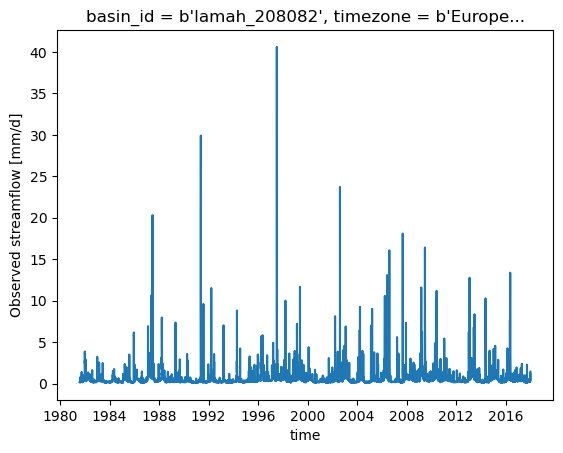

In [6]:
#quick plot of the discharge data. 
ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q']])
ds_forcing["Q"].plot()

## Calibration

The HBV model contains five stores where the water is stored and nine parameters that control the flow between those stores and in and out of the model. For the storages an array of starting values is specified. For the nine parameters, initital minimum and maximum values are stated. These values are based on ...

In [7]:
#we use the same initial conditions for all models in the ensemble

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Slowflow storage", "Groundwater storage"]

#the names of the parameters are (luckily ;-) ) also constant for all models
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]


p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001,  .01])
p_max_initial = np.array([50,    1,  800,   40,    3,     10,    1,   .1,  0.9])

# p_min_initial= np.array([0,   0.2,  1,    0.5,   0.001,   1,     0.1,  0.0001,  0.01])
# p_max_initial = np.array([50,    1.5,  3000,   30,    500,     50,    3,   3,  10])

To be able to find a good combination of parameters, a randomizer is used. It creates N possible combinations of parameters, with each of these parameters having a value in between the initial minimum and maximum values.

In [8]:
N = 100

parameters = np.random.uniform(p_min_initial[:, np.newaxis], p_max_initial[:, np.newaxis], (len(p_min_initial), N))
# print(parameters)

The next step is to run the HBV model with the forcing, the randomly chosen parameters and the initally set storage data. First of all an empty list is made, called 'ensemble'. The HBV model is run N times, with every time another set of the randomly chosen parameters from above. The outcomes of the HBV model are stored in the ensemble list.

In [9]:
ensemble = []

for counter in range(N): 
    ensemble.append(ewatercycle.models.HBVLocal(forcing=camelsgb_forcing))
    config_file, _ = ensemble[counter].setup(
                            parameters = parameters[:,counter],
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_" + str(counter),
                               )
    ensemble[counter].initialize(config_file)

To be able to determine if the outcomes of the HBV model are any good, the results can be compared to the observations. It is important to first determine when the model works good. This research focusses on the flooding threshold of the U4 subway line. Flooding happens at high discharges, peaks. This implies that the model can be seen as good, when the amount and height of the modelles peaks are similar to the peaks in the observed data. This is done with the following function. The difference between the modelled data and the observed data is raised to the fourth power, to 'punish' large absolute differences more heavy. The absolute difference between the observed data and the modelled data is higher at the peaks. In this way the parameter combination is looked for which results in the 'best' model, defined above. 

In [10]:
def calibrationObjective(modelOutput, observation, start_calibration, end_calibration):
    # a function that takes in two dataFrames, interpolates the model output to the
    # observations and calculates the average absolute difference between the two.

    #combine the two in one dataFrame
    hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1)

    #only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

    #calculate mean absolute difference to the power 4, so peaks weigh more
    diff = (hydro_data['Q'] - hydro_data['model output']) ** 4
    absDiff = np.abs(diff)
    meanAbsDiff = np.mean(absDiff)

    return meanAbsDiff

Now the differences between the model and the observed data can actually be calculated. Every ensemble is compared to the observed data. The mean absolute differences between the modelled discharges and the observed discharges are called objectives. 

In [11]:
#an object to show a progress bar, since this can take a while:
f = IntProgress(min=0, max=N) # instantiate the bar
display(f) # display the bar

#converting the observations to a pandas object
Q_pandas = ds_forcing["Q"].to_dataframe()
#an empty array to store the results in
objectives = []

#loop over all ensemble members
for ensembleMember in ensemble:
    Q_m = []
    time = []
    while ensembleMember.time < ensembleMember.end_time:
        ensembleMember.update()
        discharge_this_timestep = ensembleMember.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(ensembleMember.time_as_datetime.date()))

    #calculate the objective function 
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))
    objective_this_model = calibrationObjective(discharge_dataframe,Q_pandas["Q"],calibration_start_time,calibration_end_time)
    objectives.append(objective_this_model)

    #it is good practice to remove any variable you don't need anymore to save memory.
    del Q_m, time, discharge_dataframe, objective_this_model
   
    #update progress bar
    f.value += 1

# print(objectives)  

IntProgress(value=0)

In [12]:
#finaly, just like before, we remove the models themselves to save up space and memory.
for ensembleMember in ensemble:
    ensembleMember.finalize()

Now the results can be analyzed. The parameter set that results in the lowest objective value, is the best found parameter combination to calibrate the model to the observations.  

In [13]:
import matplotlib.pyplot as plt

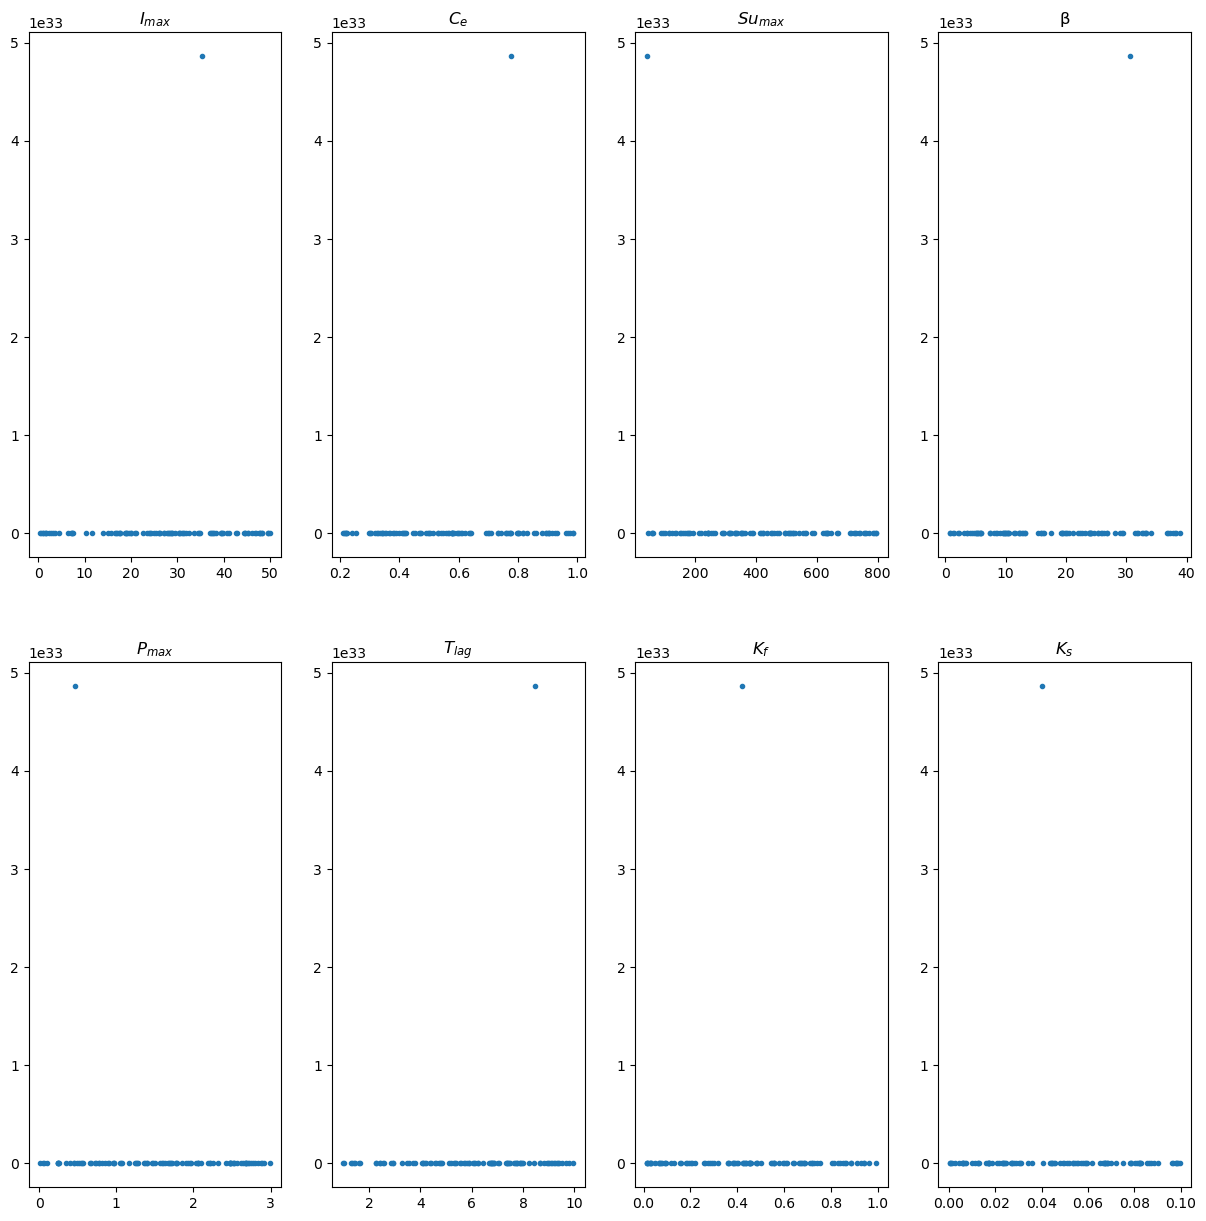

In [14]:
xFigNr = 2
yFigNr = 4

fig, axs = plt.subplots(xFigNr, yFigNr,figsize = (15,15))

for xFig in range(xFigNr):
    for yFig in range(yFigNr):
        paramCounter = xFig*yFigNr + yFig
        axs[xFig,yFig].plot(parameters[paramCounter,:],objectives,'.')
        axs[xFig,yFig].set_title(p_names[paramCounter])

In [15]:
#let's also show the minimal values:
parameters_minimum_index = np.argmin(np.array(objectives))

objective_minimum = np.min(objectives)

parameters_minimum = parameters[:,parameters_minimum_index]

print("Best parameter set:", parameters_minimum)
print("Objective: ", objective_minimum)

Best parameter set: [2.79686606e+01 6.41873341e-01 7.60557349e+02 1.22966093e+00
 1.93283574e+00 1.29510336e+00 6.90860987e-01 6.20989437e-03
 2.02025622e-01]

Objective:  326.33132342305606

We can compare the modelled discharge to the observed discharge by plotting both. First a model object needs to be created. Following, a configuration file is created that cotains information on the location of the forcing files and the values of the inital storages and the parameters. Then the model gets primed to start running through initializing.

In [16]:
par_0 = parameters_minimum
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)
model.initialize(config_file)

Now the model can start running.

In [17]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [18]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

The modelled discharge and the observed discharge can be plotted to determine the accuracy of the model.

Text(0, 0.5, 'Discharge (mm/d)')

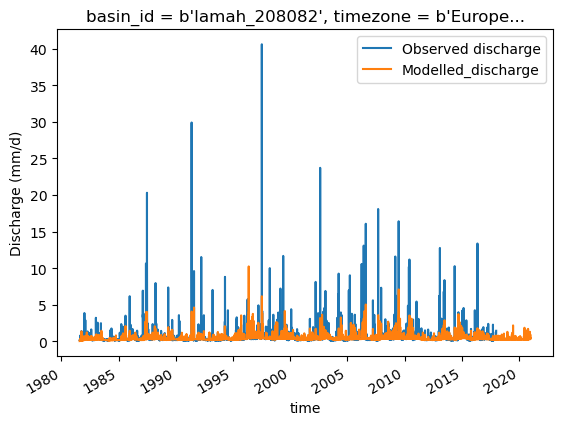

In [19]:
ds_forcing["Q"].plot(label="Observed discharge")
model_output.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")

To be able to use the output of the model in other analyses, it is saved as a NetCDF file:

In [20]:
xr_model_output = model_output.to_xarray()

xr_model_output.attrs['units'] = 'mm/d'

# Save the xarray Dataset to a NetCDF file
xr_model_output.to_netcdf('~/river_discharge_data.nc')

## Future climate change scenarios